In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../src

/Users/ranykeddo/src/github.com/feldberlin/timething/src


In [2]:
from dataclasses import replace
from pathlib import Path

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align, viz 

# Timething API

Here's an example use of the Timething API. Let's use it to take a look at the alignment for a single track. Let's set up:

In [3]:
# config
fixtures_path = Path("../fixtures")
aligments_path = fixtures_path / "alignments"
metadata = fixtures_path / "text.csv"
cfg = utils.load_config("english", local_files_only=True)
device = "cpu"

# aligner
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
aligner = align.Aligner.build(device, cfg)
ds.clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab)

# loader
loader = DataLoader(
    ds,
    batch_size=3,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

/Users/ranykeddo/anaconda3/envs/timething/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Let's pull up some recordings:

In [4]:
xs, ys, ys_original, ids  = next(iter(loader))

In [5]:
for y, y_original, id in zip(ys, ys_original, ids):
    print(f"{id}: '{y_original}'. Cleaned: '{y}'")
    display(ipd.Audio(fixtures_path / id))

audio/one.mp3: 'One!'. Cleaned: 'one'


audio/two.mp3: 'Two?'. Cleaned: 'two'


audio/born.mp3: 'Born in 1969 in Belgrade.'. Cleaned: 'born|in|nineteen|sixty-nine|in|belgrade'


Let's align them.

In [6]:
alignments = aligner.align_batch((xs, ys, ys_original, ids))

The last example: Born in 1969 in Belgrade:

In [7]:
recording_idx = 2
id = ids[recording_idx]
y = ys[recording_idx]
y_original = ys_original[recording_idx]
alignment = alignments[recording_idx]

First let's take a look at the frame-wise log probabilities.

Visualisations taken from the [pytorch alignment tutorial](https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html), Original Author: Moto Hira <moto@fb.com>.

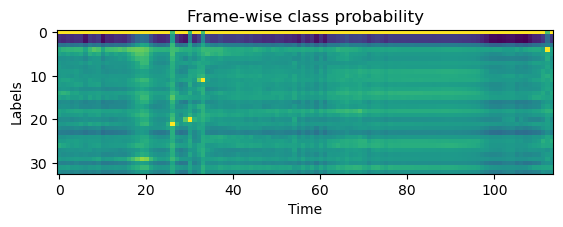

In [8]:
plt.imshow(alignment.log_probs[0].T)
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels");

The probability trellis for this recording:

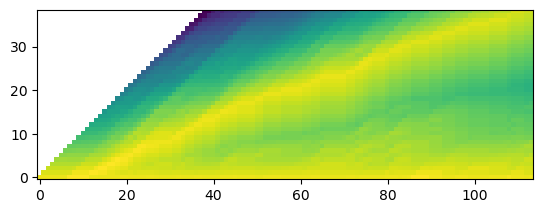

In [9]:
plt.imshow(alignment.trellis[1:, 1:].T, origin="lower");

The best path through the trellis:

In [10]:
import math
math.exp(alignment.log_probs[0].T[0, 9].item())

0.9999870063564401

In [11]:
alignment.path

[Point(token_index=0, time_index=7, score=0.9999217987060547),
 Point(token_index=0, time_index=8, score=0.9999910593032837),
 Point(token_index=0, time_index=9, score=0.9999924898147583),
 Point(token_index=0, time_index=10, score=0.9999966621398926),
 Point(token_index=0, time_index=11, score=0.9999951124191284),
 Point(token_index=1, time_index=12, score=0.9999819993972778),
 Point(token_index=1, time_index=13, score=0.9995548129081726),
 Point(token_index=2, time_index=14, score=0.9992334842681885),
 Point(token_index=2, time_index=15, score=0.999976396560669),
 Point(token_index=3, time_index=16, score=0.9999631643295288),
 Point(token_index=3, time_index=17, score=0.9977306723594666),
 Point(token_index=4, time_index=18, score=0.9993071556091309),
 Point(token_index=4, time_index=19, score=0.010352220386266708),
 Point(token_index=4, time_index=20, score=0.9891204833984375),
 Point(token_index=5, time_index=21, score=0.9995977282524109),
 Point(token_index=6, time_index=22, score

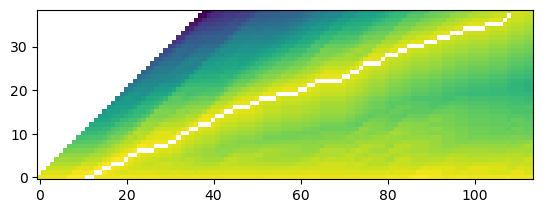

In [12]:
viz.plot_trellis_with_path(alignment.trellis, alignment.path);

The cleaned aligned characters:

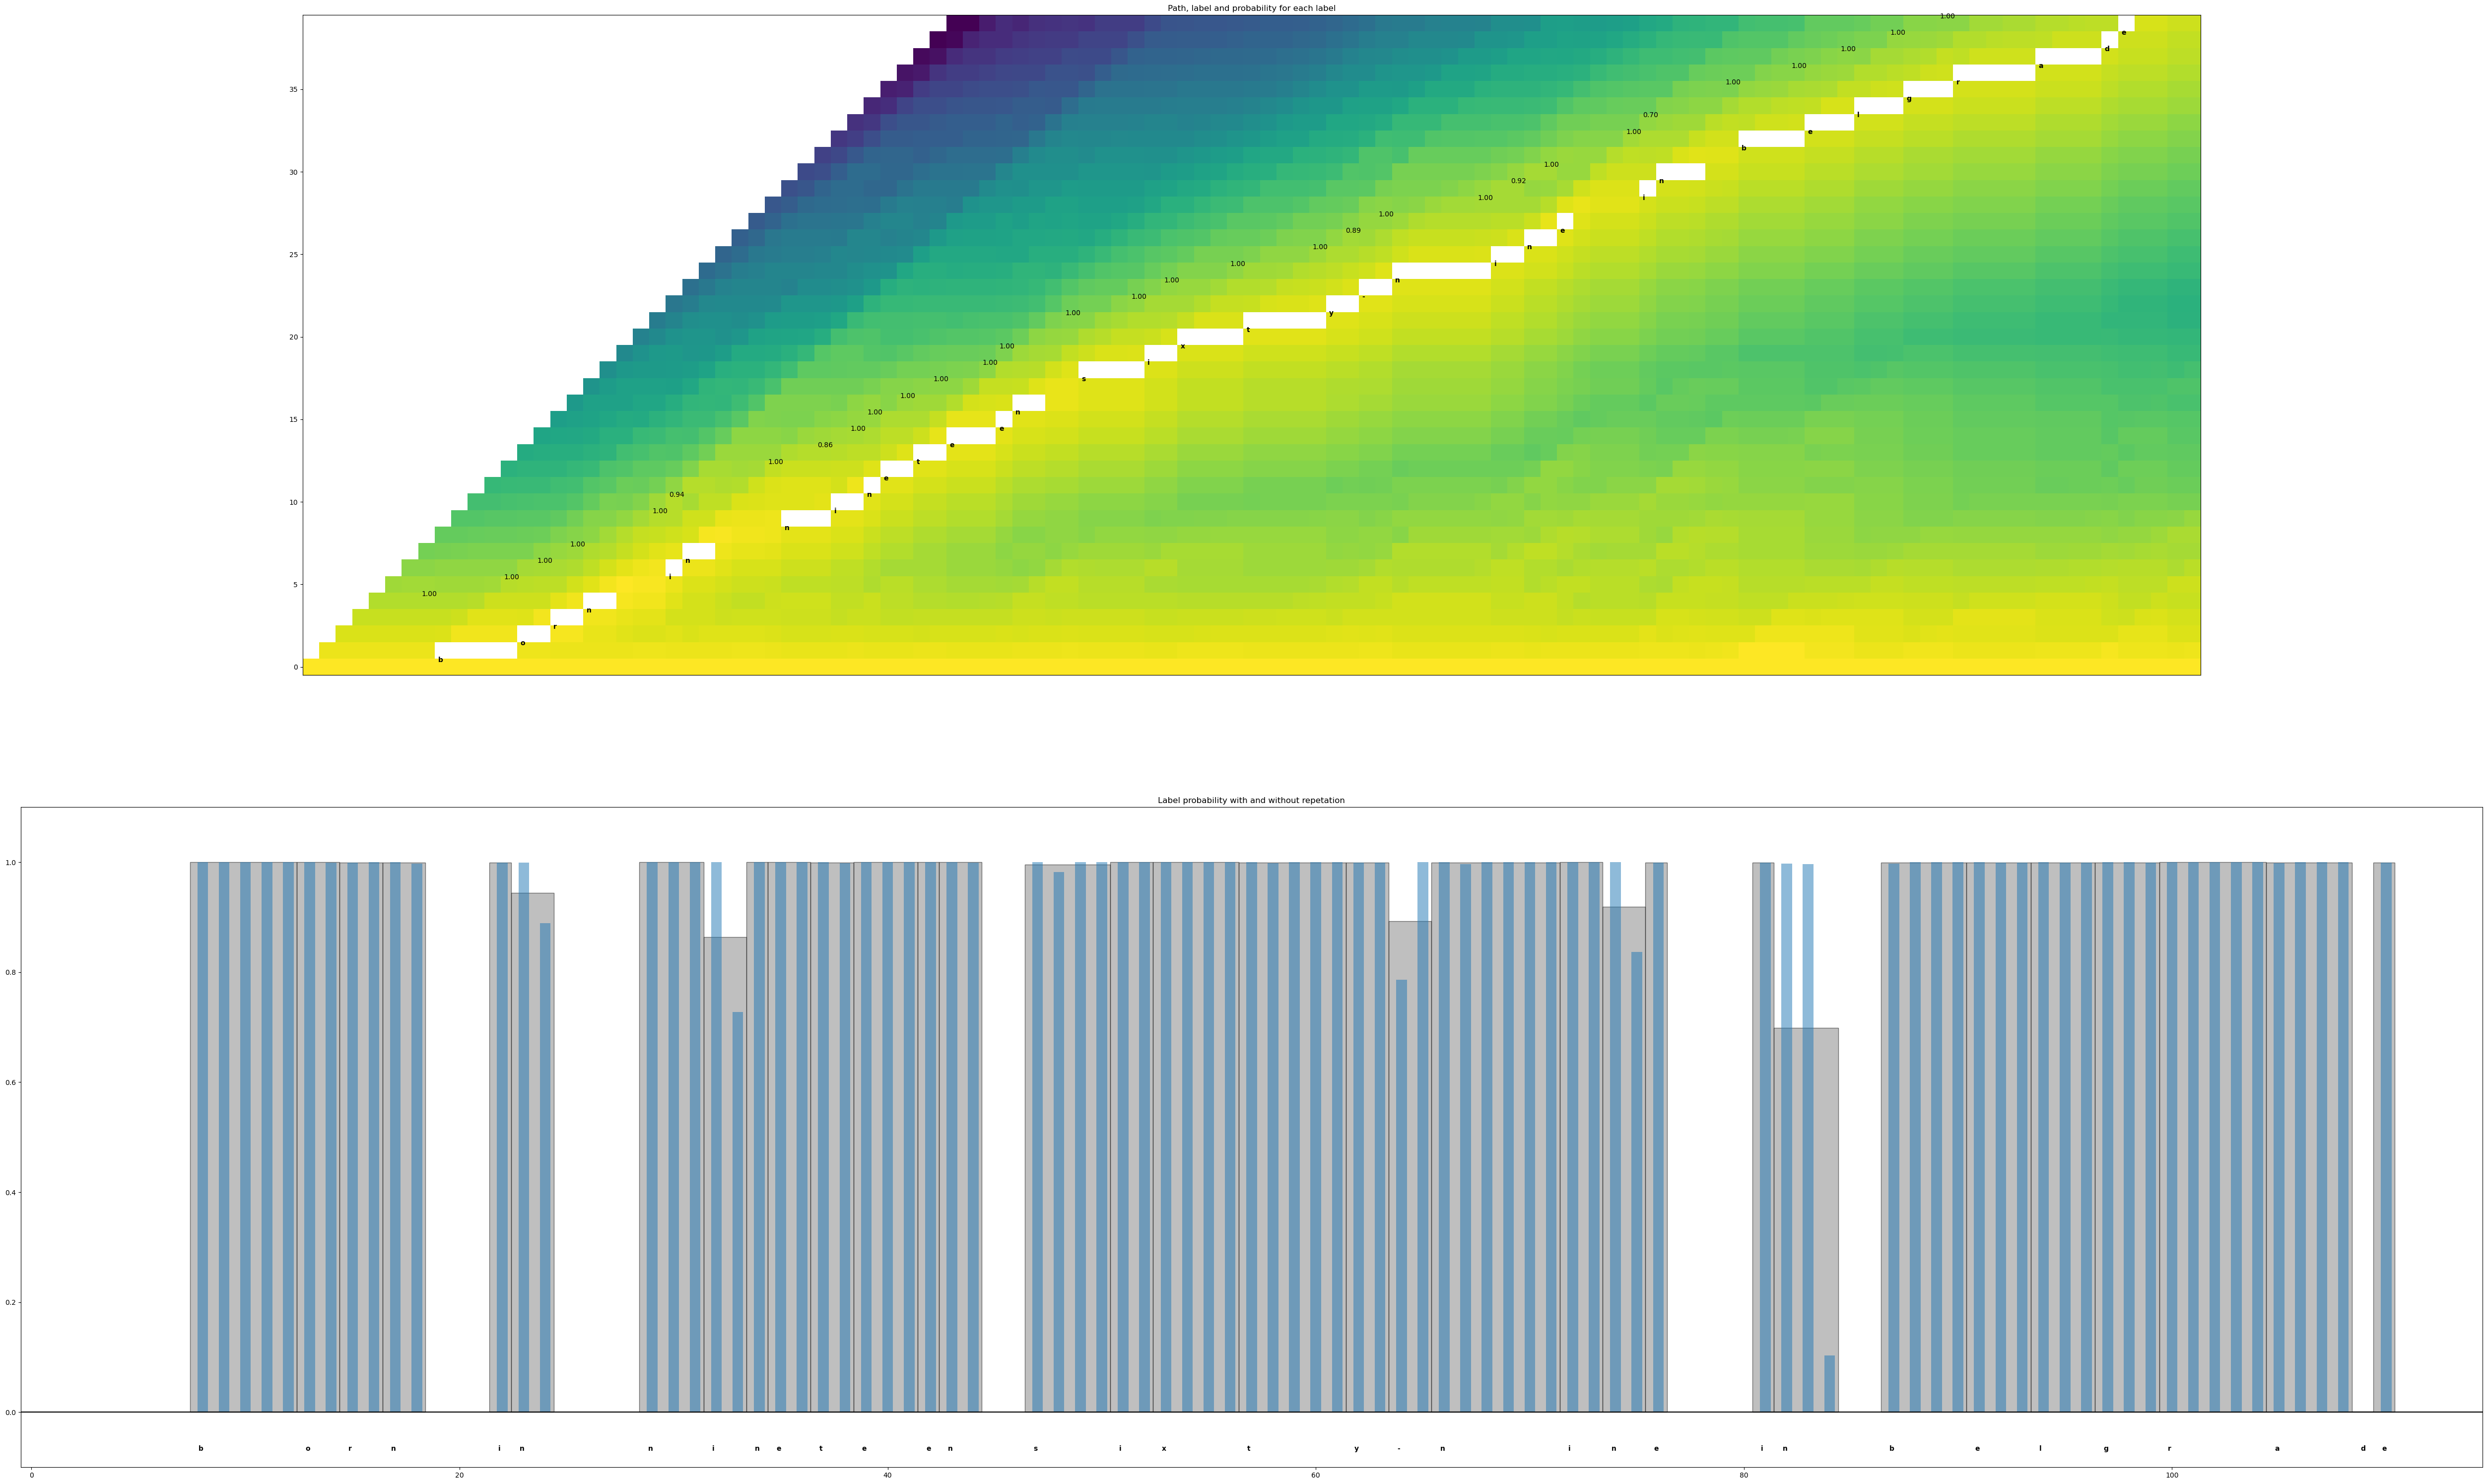

In [13]:
viz.plot_trellis_with_segments(alignment.trellis, alignment.chars_cleaned, y, alignment.path);

In [14]:
alignment.chars_cleaned

[Segment(label='b', start=7, end=12, score=0.9999794244766236),
 Segment(label='o', start=12, end=14, score=0.9997684061527252),
 Segment(label='r', start=14, end=16, score=0.9996049404144287),
 Segment(label='n', start=16, end=18, score=0.9988469183444977),
 Segment(label='|', start=18, end=21, score=0.6662599531312784),
 Segment(label='i', start=21, end=22, score=0.9995977282524109),
 Segment(label='n', start=22, end=24, score=0.9443306624889374),
 Segment(label='|', start=24, end=28, score=0.6324233328850823),
 Segment(label='n', start=28, end=31, score=0.9999643564224243),
 Segment(label='i', start=31, end=33, score=0.863690197467804),
 Segment(label='n', start=33, end=34, score=0.9999845027923584),
 Segment(label='e', start=34, end=36, score=0.9999786615371704),
 Segment(label='t', start=36, end=38, score=0.9992376267910004),
 Segment(label='e', start=38, end=41, score=0.9999486605326334),
 Segment(label='e', start=41, end=42, score=0.9999748468399048),
 Segment(label='n', start=4

In [15]:
alignment.words_cleaned

[Segment(label='born', start=7, end=18, score=0.9282226794000182),
 Segment(label='in', start=21, end=24, score=0.7739931978243736),
 Segment(label='nineteen', start=28, end=44, score=0.9272806859161291),
 Segment(label='sixty-nine', start=46, end=76, score=0.9587509490460541),
 Segment(label='in', start=80, end=84, score=0.8219997175037861),
 Segment(label='belgrade', start=86, end=110, score=0.9579451212727387)]

In [16]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_words(words):
    for word in words:
        start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
        end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
        y, sr = utils.load_slice(fixtures_path / id, start_seconds, end_seconds)
        print(f"{word.label} ({word.start}:{word.end})")
        ipd.display(ipd.Audio(y, rate=sr))
        
show_words(alignment.words_cleaned)

born (7:18)


in (21:24)


nineteen (28:44)


sixty-nine (46:76)


in (80:84)


belgrade (86:110)


Looks reasonable. Now for the original versions:

In [17]:
alignment.chars

[Segment(label='B', start=7, end=12, score=0.9999794244766236),
 Segment(label='o', start=12, end=14, score=0.9997684061527252),
 Segment(label='r', start=14, end=16, score=0.9996049404144287),
 Segment(label='n', start=16, end=18, score=0.9988469183444977),
 Segment(label=' ', start=18, end=21, score=0.6662599531312784),
 Segment(label='i', start=21, end=22, score=0.9995977282524109),
 Segment(label='n', start=22, end=24, score=0.9443306624889374),
 Segment(label=' ', start=24, end=28, score=0.6324233328850823),
 Segment(label='1969', start=28, end=76, score=0.9999643564224243),
 Segment(label=' ', start=76, end=80, score=0.7500359404075425),
 Segment(label='i', start=80, end=81, score=0.9991487264633179),
 Segment(label='n', start=81, end=84, score=0.6991770838697752),
 Segment(label=' ', start=84, end=86, score=0.9176591634750366),
 Segment(label='B', start=86, end=90, score=0.999280720949173),
 Segment(label='e', start=90, end=93, score=0.9994173447291056),
 Segment(label='l', star

In [18]:
alignment.words

[Segment(label='Born', start=7, end=18, score=0.9282226794000182),
 Segment(label='in', start=21, end=24, score=0.7739931978243736),
 Segment(label='1969', start=28, end=76, score=0.9807390936520488),
 Segment(label='in', start=80, end=84, score=0.8219997175037861),
 Segment(label='Belgrade.', start=86, end=110, score=0.9579451212727387)]

In [19]:
show_words(alignment.words)

Born (7:18)


in (21:24)


1969 (28:76)


in (80:84)


Belgrade. (86:110)
